In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [37]:
df=pd.read_excel("nba_2026_all_players_average_per_game.xlsx",index_col=0)

In [38]:
df["Def_activity"] = (df["STL"] + df["BLK"])

In [39]:
df_top = df.sort_values("MP", ascending=False).head(200)

In [40]:
style_cols = ["AST","3P","2P","TRB","Def_activity","FGA"]
X_scaled = StandardScaler().fit_transform(df_top[style_cols])

In [41]:
kmeans = KMeans(n_clusters=5, random_state=42)
df_top["Cluster"] = kmeans.fit_predict(X_scaled)

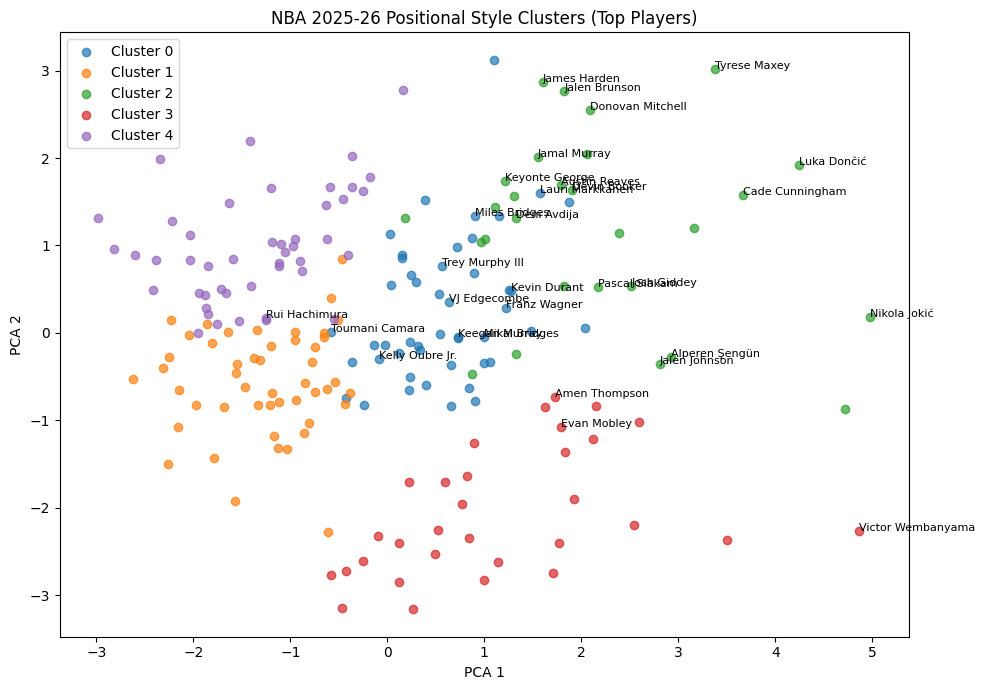

In [42]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

df_top["x"] = coords[:, 0]
df_top["y"] = coords[:, 1]


plt.figure(figsize=(10, 7))

for c in sorted(df_top["Cluster"].unique()):
    temp = df_top[df_top["Cluster"] == c]
    plt.scatter(temp["x"], temp["y"], label=f"Cluster {c}", alpha=0.7)

plt.title("NBA 2025-26 Positional Style Clusters (Top Players)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()

label_df = df_top.sort_values("MP", ascending=False).head(30)
for _, row in label_df.iterrows():
    plt.text(row["x"], row["y"], row["Player"], fontsize=8)

plt.tight_layout()
plt.show()

In [51]:
out_cols = [
    "Player", "Pos", "Age", "Team", "G", "MP", "PTS", "3P", "2P", "FGA", "TRB", "AST", "STL", "BLK",
    "Def_activity", "Cluster"
]

df_top[out_cols].to_excel("Cluster.xlsx", index=False)

In [52]:
cluster_stats = df_top.groupby("Cluster")[["PTS","AST","TRB","STL","BLK","MP","3P","2P","Def_activity","FGA"]].mean().round(2)
print(cluster_stats)

           PTS   AST   TRB   STL   BLK     MP    3P    2P  Def_activity    FGA
Cluster                                                                       
0        18.74  3.23  5.54  1.18  0.68  31.56  2.10  4.55          1.86  14.20
1        10.19  2.82  4.32  0.95  0.42  26.31  1.10  2.59          1.37   8.00
2        24.51  7.33  6.20  1.20  0.42  33.82  2.09  6.35          1.62  17.44
3        15.50  2.69  8.90  1.16  1.16  29.20  0.51  5.53          2.32  10.91
4        14.28  2.72  3.29  0.78  0.27  28.07  2.50  2.32          1.05  10.78


In [53]:
for c in sorted(df_top["Cluster"].unique()):
    print(f"\nCluster {c} example players:")
    print(df_top[df_top["Cluster"] == c].sort_values("MP", ascending=False).head(5)[["Player","PTS","AST","TRB","MP"]])


Cluster 0 example players:
             Player   PTS  AST  TRB    MP
Rk                                       
58    Keegan Murray  18.7  1.3  7.3  38.0
94     VJ Edgecombe  15.6  4.2  6.0  37.3
20     Kevin Durant  24.6  3.3  4.8  36.1
8   Lauri Markkanen  28.5  2.2  6.1  35.6
46  Trey Murphy III  20.2  3.1  6.3  35.3

Cluster 1 example players:
                 Player   PTS  AST  TRB    MP
Rk                                           
200       Herbert Jones   9.5  2.3  3.8  30.3
112       Tobias Harris  13.9  2.9  5.3  30.3
179     Davion Mitchell  10.3  7.3  2.9  30.1
139  Wendell Carter Jr.  12.3  2.0  7.4  29.9
156     Christian Braun  11.4  3.0  4.4  29.5

Cluster 2 example players:
             Player   PTS  AST  TRB    MP
Rk                                       
2      Tyrese Maxey  33.0  7.8  4.6  40.4
1       Luka Dončić  34.5  8.9  8.8  37.1
34   Alperen Şengün  22.4  7.1  9.7  36.7
13    Austin Reaves  27.6  7.3  5.5  36.4
14  Cade Cunningham  27.1  9.6  6.0  36.4

Clust

In [66]:
df = pd.read_excel("Cluster.xlsx")

STYLE_COLS = ["AST", "3P", "2P", "TRB", "Def_activity", "FGA"]

# Make sure all style cols are numeric
for col in STYLE_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[STYLE_COLS])

# Store scaled values in z_ columns (optional but convenient)
for i, col in enumerate(STYLE_COLS):
    df[f"z_{col}"] = X_scaled[:, i]


def find_similar_players(df, player_name, top_n=5, same_cluster_only=False):
    """
    Find players with the most similar statistical style to `player_name`.

    Similarity is based on standardized (z-scored):
    AST, 3P, 2P, TRB, Def_activity, FGA
    """

    # locate the player row (case-insensitive)
    mask = df["Player"].str.lower() == player_name.lower()
    if not mask.any():
        raise ValueError(f"Player '{player_name}' not found in dataframe.")

    idx = df[mask].index[0]
    player_row = df.loc[idx]

    # style vector for this player (scaled)
    z_cols = [f"z_{c}" for c in STYLE_COLS]
    player_vec = player_row[z_cols].values.astype(float)

    # matrix of all players' style vectors
    all_vecs = df[z_cols].values.astype(float)

    # Euclidean distance to every other player
    dists = np.linalg.norm(all_vecs - player_vec, axis=1)

    df_temp = df.copy()
    df_temp["distance"] = dists

    # optionally restrict to players in the same cluster
    if "Cluster" in df.columns and same_cluster_only:
        same_cluster = player_row["Cluster"]
        df_temp = df_temp[df_temp["Cluster"] == same_cluster]

    # exclude the player themself
    df_temp = df_temp[df_temp.index != idx]

    # sort by distance (smallest = most similar)
    df_temp = df_temp.sort_values("distance").head(top_n)

    # nice columns to show
    cols_show = [
        "Player", "Pos", "Tm", "PTS", "AST", "TRB", "STL", "BLK",
        "MP", "Cluster", "distance"
    ]
    cols_show = [c for c in cols_show if c in df_temp.columns]

    return df_temp[cols_show]


print(find_similar_players(df, "Kon Knueppel"))
print(find_similar_players(df, "Victor Wembanyama"))
print(find_similar_players(df, "James Harden"))

              Player Pos   PTS  AST  TRB  STL  BLK    MP  Cluster  distance
81     Aaron Nesmith  SF  15.5  1.5  4.5  0.8  0.3  30.5        4  1.360798
127    Aaron Wiggins  SG  14.8  2.2  3.7  0.4  0.8  27.6        4  1.388737
99       CJ McCollum  SG  16.5  3.3  3.3  0.7  0.3  29.3        4  1.531463
16     Miles Bridges  PF  22.0  3.8  6.5  0.7  0.6  34.9        0  1.547682
104  De'Andre Hunter  SF  18.1  2.8  4.8  0.7  0.2  28.9        4  1.553307
             Player Pos   PTS  AST   TRB  STL  BLK    MP  Cluster  distance
46   Scottie Barnes  PF  19.2  5.1   7.8  1.5  1.7  32.9        3  3.346593
94    Anthony Davis  PF  20.8  2.2  10.2  1.6  1.2  29.8        3  3.529212
22      Evan Mobley  PF  18.7  3.9   8.7  1.1  1.6  34.2        3  3.900531
107       Alex Sarr   C  18.1  3.6   8.4  0.6  2.0  28.9        3  3.911298
50    Kawhi Leonard  SF  23.7  3.3   5.3  2.6  0.6  32.6        0  4.029172
           Player Pos   PTS  AST  TRB  STL  BLK    MP  Cluster  distance
78    LaMelo Ba